<style>
  .md-typeset h1,
  .md-content__button {
    display: none;
  }
</style>

<h2>How to create your Multi Agent System with Custom Agents</h2>

<a href="https://github.com/aws-samples/amazon-bedrock-samples/agents/build-your-own-agent/how_to_create_multi_agents_from_custom_agents.ipynb">Open in GitHub</a>

<h2>Overview</h2>

We will be first creating an agent from scratch using the Amazon Bedrock Converse API. <strong>This is useful when the existing tools in popular frameworks don't support the type of agent you want to build, or if they have extra bit of code that you don't need for your specific use case or is slowing down your application. Building an agent from scratch also helps you understand how agents work internally.</strong> 

Then we shall leverage it to build a Multi Agent System, where multiple Agents work together to acheive a complex task.

Before we start, let's cover a few important concepts.

Agents are systems that use Large Language Models (LLMs) as their reasoning engines to decide what actions to take and what inputs to provide. After executing actions, the results can be fed back into the LLM to determine if more actions are needed or if it's okay to finish.

Agents have access to different tools or functions that allow the LLM to interact with external APIs and automate tasks, resolve queries, and much more.

In this tutorial, we will build a simple agent from scratch. We shall use to build two different agents, one which specializes in collecting information from the web and another that can write and execute code. Then we will use these two agents together to achieve the multi agent orchestration.

<div class="alert alert-block alert-info">
<b>Note:</b> This notebook has been tested in <strong>Mumbai (ap-south-1)</strong> in <strong>Python 3.10.14</strong>
</div>

<h2>Architecture</h2>

Following is the Architecture Daigram,

<img src="./assets/multi_agent.drawio.png" alt="Multi Agent Architecture" style="margin:auto">


<h2>Prerequisites</h2>

Apart from the libraries that we will be installing, this notebook requires permissions to:

<ul>
<li>access Amazon Bedrock</li>
</ul>

If running on SageMaker Studio, you should add the following managed policies to your role:
<ul>
<li>AmazonBedrockFullAccess</li>
</ul>

<div class="alert alert-block alert-info">
<b>Note:</b> Please make sure to enable `Anthropic Claude 3 Sonnet` model access in Amazon Bedrock Console, as the notebook will use Anthropic Claude 3 Sonnet model.
</div>

In [1]:
!pip install -Uq langchain_experimental==0.0.64 duckduckgo-search

<h2>Setup</h2>

We next import the required libraries

In [2]:
import json
import io
from IPython.display import display
from duckduckgo_search import DDGS

import pprint
import random
import boto3
import sys
from io import StringIO
from colorama import Fore

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
region = 'us-west-2'

session = boto3.session.Session(region_name=region)
bedrock_client = session.client('bedrock-runtime')

<h2>Code</h2>

We will now define the necessary subroutines for our agent to function. 

<h3>Defining the Tools</h3>

The first step in creating our Agent is to define the tools it can access. In our case, we'll be defining local Python functions, but it's important to note that these tools could be any type of application service. On AWS, these tools might include:

<ul>
<li>An AWS Lambda function</li>
<li>A connection to an Amazon RDS database</li>
<li>An Amazon DynamoDB table</li>
</ul>


Other examples of tools could be:
<ul>
<li>REST APIs</li>
<li>Data warehouses, data lakes, and databases</li>
<li>Computation engines</li>
</ul>


For our Agent, we'll define two tools as Python functions with the following abilities:
<ol>
<li>Retrieve web search results from the DuckDuckGo search engine using natural language as input.</li>
<li>Execute Python code provided by the Agent to generate charts using the Matplotlib library.</li>
</ol>


In simple terms, we're giving our Agent access to two tools: one that can perform web searches based on natural language queries, and another that can create visual charts and graphs from Python code. These tools will enable our Agent to gather information and present it in a visual format, which can be useful for various tasks and applications.


Following code defines two functions: `chat_generator_from_python_code` and `web_search`. The first function executes Python code to generate a chart, handling any exceptions and returning the result. The second function performs a web search using the DDGS (DuckDuckGo Search) library and returns the search results. Additionally, there's a `call_function` utility that will help us orchestrate the function calls by abstracting the tool name.

In [3]:
from langchain_experimental.utilities import PythonREPL

def chat_generator_from_python_code(code: str) -> str:
    """
    Function to executes the python code to generate the chart.
    Args:
        code: The python code that will generate the chart.
    """
    repl = PythonREPL()
    try:
        result = repl.run(code)
    except Exception as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Code has generated the chart successfully.\n{result}"
    return result_str


def web_search(query: str) -> str:
    """
    Function to research and collect more information to answer the query
    Args:
        query: The query that needs to be answered or more information needs to be collected.
    """
    try:
        results = DDGS().text(keywords=query, region='in-en', max_results=5)
        return '\n'.join([json.dumps(result) for result in results])
    except Exception as e:
        return f"Failed to search. Error: {e}"


def call_function(tool_name, parameters):
    func = globals()[tool_name]
    output = func(**parameters)
    return output

Following is a sample execution of the web search function.

In [4]:
query = "What is the capital of India"
print(f"Query for Web search: \n{query}")
data = call_function('web_search', {'query': query})

print(f"Following is the output of web search: {data}")

Query for Web search: 
What is the capital of India
Following is the output of web search: {"title": "New Delhi | History, Population, Map, & Facts | Britannica", "href": "https://www.britannica.com/place/New-Delhi", "body": "New Delhi, national capital of India.It is situated in the north-central part of the country on the west bank of the Yamuna River, adjacent to and just south of Delhi city (Old Delhi) and within the Delhi national capital territory.. In December 1911 King George V of Britain decreed that the capital of British India would be moved from Calcutta (now Kolkata) to Delhi.Construction began in 1912 at a site about 3 miles (5 km) south of the Delhi city centre, and the new capital was formally ..."}
{"title": "New Delhi - Wikipedia", "href": "https://en.wikipedia.org/wiki/New_Delhi", "body": "New Delhi (/ \u02c8 nj u\u02d0 \u02c8 d \u025b. l i / \u24d8, [6] Hindi: [\u02c8n\u0259i\u02d0 \u02c8d\u026al\u02d0i\u02d0], ISO: Na\u012b Dill\u012b) is the capital of India and a

Now that we have functions defined that are to be used as tools, we will next define the `toolConfig` (i.e. `toolConfig_websearch` & `toolConfig_pythonrepl`) for our two worker agents in the format required by the Bedrock Converse API to let the corresponding Agents know about the tools available to them.

It should be noted that each agent can handle multiple tools, and the setting that allows the model to automatically decide if a tool should be called or whether to generate text instead is controlled by `toolChoice` to `{auto: {}}`.

In [5]:
toolConfig_websearch = {
    'tools': [
        {
            'toolSpec': {
                'name': 'web_search',
                'description': 'Fetch information about any query from the internet.',
                'inputSchema': {
                    'json': {
                        'type': 'object',
                        'properties': {
                            'query': {
                                'type': 'string',
                                'description': 'Query for which more information is required.'
                            }
                        },
                        'required': ['query']
                    }
                }
            }
        }
    ],
    'toolChoice': {
        'auto': {}
    }
}

toolConfig_pythonrepl = {
        'tools': [
            {
                'toolSpec': {
                    'name': 'chat_generator_from_python_code',
                    'description': 'Generates the charts from python code',
                    'inputSchema': {
                        'json': {
                            'type': 'object',
                            'properties': {
                                'code': {
                                    'type': 'string',
                                    'description': 'Syntactically correct Python code that will generate the charts'
                                }
                            },
                            'required': ['code']
                        }
                    }
                }
            }
        ],
        'toolChoice': {
            'auto': {}
        }
    }

<h3>Sample Custom Agent</h3>

Following `agent` class is designed to facilitate the interaction between a user and a language model (LLM) through a conversational interface. This implementation allows the LLM to call a single tool at a time, preventing it from getting stuck in a tool-calling loop. However, extending the functionality to plan and handle a series of tool calls can be implemented, albeit non-trivially.

The class initializes with a `toolConfig`, `system_prompt`, `messages` which is an optional list and `color` another optional parameter which takes in a string ("BLACK", "RED", "GREEN", "YELLOW", "BLUE", "MAGENTA", "CYAN") stating the color of the output print statements of that agent.

The `call_converse_api_with_tools` method invokes the LLM by sending messages and the tool configuration, handling any exceptions that may occur.

The `handle_tool_use` method validates and calls the appropriate tool based on the provided tool name and parameters. If an unexpected tool is used, it raises an exception.

The `process_user_input` method is the core of the class. It appends the user's input to the list of messages, invokes the LLM, and processes the response. If the LLM's response includes tool usage instructions, the method calls the specified tool(s) and incorporates the tool's output into the conversation. This process continues until the LLM provides a final answer or the maximum number of retries is reached.

The `check_for_final_answer` method checks if the LLM's response includes a final answer to the user's query based on the conversation history.

The `invoke` method is the entry point for the user's input. It attempts to obtain a final answer by calling `process_user_input` and `check_for_final_answer` methods up to a maximum number of retries. If a final answer is not found within the specified number of retries, it returns the entire conversation history.

Overall, this agent class provides a conversational interface for users to interact with an LLM while enabling the LLM to leverage external tools. The implementation ensures that the LLM does not get stuck in a tool-calling loop by handling one tool at a time.

In [6]:
class agent:
    def __init__(self, toolConfig, system_prompt, messages=[], color='BLACK'):
        self.bedrock_client = bedrock_client
        self.model_id = modelId
        self.messages = messages
        self.max_retires = 5
        self.tool_max_invocations = 5
        self.toolConfig = toolConfig
        self.system_prompt = [
            {
                "text": system_prompt
            }
        ]
        # Logging colors
        self.logging_color = color
        self.color_dict = {
            "BLACK": Fore.BLACK, "RED": Fore.RED, "GREEN": Fore.GREEN, "YELLOW": Fore.YELLOW, "BLUE": Fore.BLUE, "MAGENTA": Fore.MAGENTA, "CYAN": Fore.CYAN
        }

    def call_converse_api_with_tools(self, messages):
        try:
            response = self.bedrock_client.converse(
                modelId=self.model_id,
                system=self.system_prompt,
                messages=messages,
                toolConfig=self.toolConfig
            )
            return response
        except Exception as e:
            return {"error": str(e)}

    def handle_tool_use(self, func_name, func_params):
        allowed_tools = [
            tool['toolSpec']['name'] for tool in self.toolConfig['tools']
        ]
        if func_name in allowed_tools:
            results = call_function(func_name, func_params)
            return results
        raise Exception("An unexpected tool was used")

    def process_user_input(self, user_input):
        self.messages.append(
            {
                "role": "user",
                "content": [
                    {
                        "text": user_input
                    }
                ]
            }
        )
        print(self.color_dict[self.logging_color] + "Invoking LLM")
        response_message = self.call_converse_api_with_tools(
           messages=self.messages,
        )
        if "error" in response_message:
            return f"An error occurred: {response_message['error']}"
        # Add the intermediate output to the list of messages
        self.messages.append(response_message['output']['message'])
        agent_final_response = response_message['output']['message']['content'][0].get('text', "Agent is Trying to call the tool, but tool not found hence this response")
        print(self.color_dict[self.logging_color] + "Received message from the LLM")
        tool_invocation_count = 0
        while tool_invocation_count < self.tool_max_invocations:
            function_calling = [
                c['toolUse'] for c in response_message['output']['message']['content'] if 'toolUse' in c
            ]
            if function_calling:
                tool_invocation_count += 1
                print(self.color_dict[self.logging_color] + f"Function Calling - List of function calls : {function_calling}")
                tool_result_message = {"role": "user", "content": []}
                for function in function_calling:
                    tool_name = function['name']
                    tool_args = function['input'] or {}
                    # print(self.color_dict[self.logging_color] + f"Function calling - Calling Tool :{tool_name}(**{tool_args})")
                    print(self.color_dict[self.logging_color] + f"Function calling - Calling Tool")
                    tool_response = self.handle_tool_use(tool_name, tool_args)
                    # print(self.color_dict[self.logging_color] + f"Function calling - Got Tool Response: {tool_response}")
                    print(self.color_dict[self.logging_color] + f"Function calling - Received Tool Response")
                    tool_result_message['content'].append({
                        'toolResult': {
                            'toolUseId': function['toolUseId'],
                            'content': [{"text": tool_response}]
                        }
                    })
                # Add the intermediate tool output to the list of messages
                self.messages.append(tool_result_message)
                print("Function calling - Calling LLM with Tool Result")
                response_message = self.call_converse_api_with_tools(
                   messages=self.messages
                )
                if "error" in response_message:
                    return f"An error occurred: {response_message['error']}"
                # Add the intermediate output to the list of messages
                self.messages.append(response_message['output']['message'])
                print(self.color_dict[self.logging_color] + "Function calling - Received message from the LLM")
                if len(response_message['output']['message']['content']) > 0:
                    agent_final_response = response_message['output']['message']['content'][0].get('text', "Agent received output from the tool, but text response from agent not found so the answer needs to be figured out form the previous messages.")
                else:
                    agent_final_response = "Agent received output from the tool, but text response from agent not found so the answer needs to be figured out form the previous messages."
            else:
                break
        if tool_invocation_count >= self.tool_max_invocations:
            agent_final_response = "Agent ended up in a tool invocation loop, extract the information available in the previous information to answer user's query."
        # return response_message['output']['message']['content'][0]['text']
        return agent_final_response

    def check_for_final_answer(self, user_input, ai_response):
        messages = []
        for message in self.messages:
            _m = {
                'role': message['role'],
                'content': []
            }
            for _c in message['content']:
                if 'text' in _c.keys():
                    _m['content'].append(_c)
                if 'toolUse' in _c.keys():
                    tool_inputs = ','.join([ f"{x}={_c['toolUse']['input'][x]}" for x in _c['toolUse']['input'].keys()])
                    _tool_use_c = {
                        "text": f"Tool : {_c['toolUse']['name']} Called with the input: {tool_inputs}"
                    }
                    _m['content'].append(_tool_use_c)
                elif 'toolResult' in _c.keys():
                    _m['content'].extend(_c['toolResult']['content'])
            messages.append(_m)
        messages.append({
            "role": "user",
            "content": [
                {
                    "text": f"User Query: {user_input}\nAI Response: {ai_response}"
                }
            ]
        })
        # print(messages)
        try:
            response = self.bedrock_client.converse(
                modelId=self.model_id,
                system=[
                    {
                        "text": f"""You are an expert at extracting the answer to user's query in the AI's response.
If you are not able to determine whether the query was answered then return: Sorry cannot answer the query. Please try again.
You have previous conversation to provide you the context. You should not be mentioning about the AI or any tools that were used and only focus on the answer to the user's query."""
                    }
                ],
                messages=messages
            )
            # print(response)
            return response['output']['message']['content'][0]['text']
        except Exception as e:
            return {"ERROR": str(e)}

    def invoke(self, user_input):
        for i in range(self.max_retires):
            print(self.color_dict[self.logging_color] + f"Trial {i+1}")
            response_text = self.process_user_input(user_input)
            if 'FINAL ANSWER' in response_text:
                print(10*'--')
                return response_text
            else:
                print(self.color_dict[self.logging_color] + 'LLM Parser Invoked')
                llm_parser_output = self.check_for_final_answer(user_input, response_text)
                print(self.color_dict[self.logging_color] + f'LLM Parser Output: {llm_parser_output}')
                if 'ERROR' not in llm_parser_output:
                    print(10*'--')
                    return llm_parser_output
        return '\n'.join([msg["content"][0].get('text', "<skipped> Tool Use <skipped>") for msg in self.messages])

<h3>Testing Researcher Custom Agent</h3>

We will next test out researcher agent using the agent class that was just defined by providing it with previously defined `toolConfig_websearch` and a sample system prompt.

Note: We have used `cyan` color for any output generated by the researcher agent.

In [7]:
messages = []

system_prompt = """You are a researcher AI.
Your task is to use the tools available to you and answer the user's query to the best of your capabilities.
Your answers should only come from the tools that are available wihtout any additional infomration outside the tool's responses
When you have final answer to the user's query then you are to strictly prefix it with FINAL ANSWER to stop the iterations."""

researcher_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig_websearch, messages=messages, color='CYAN')

output_researcher = researcher_agent.invoke("List the GDP United States from 2009 to 2015")

print(output_researcher)

Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_2JUpbNRSSuyXaMblnLa1LA', 'name': 'web_search', 'input': {'query': 'United States GDP 2009 to 2015'}}]
Function calling - Calling Tool
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
--------------------
The search results provide data on the GDP of the United States for various years, including the period from 2009 to 2015. Let me extract and list out those specific values:

2009: $16,785.4 billion
2010: $17,130.1 billion 
2011: $17,455.7 billion
2012: $17,715.6 billion
2013: $18,007.6 billion
2014: $18,417.1 billion
2015: $18,787.7 billion

FINAL ANSWER: The GDP of the United States from 2009 to 2015 was:

2009: $16,785.4 billion
2010: $17,130.1 billion
2011: $17,455.7 billion  
2012: $17,715.6 billion
2013: $18,007.6 billion
2014: $18,417.1 billion
2015: $18,787.7 billion


<h3>Testing Code Generation and Execution Agent with one tool</h3>

We will next test out code generator and executor agent using the agent class by providing it with previously defined `toolConfig_pythonrepl` and a sample system prompt.

We will also provide the our code generator and executor agent, the information that our researcher agent collected in regards to the user's query.

Note: We have used `green` color for any output generated by the code generation and execution agent.

Trial 1
Invoking LLM


Python REPL can execute arbitrary code. Use with caution.


Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_FtM5umVrTDui1BGlXN6jzw', 'name': 'chat_generator_from_python_code', 'input': {'code': "import matplotlib.pyplot as plt\n\nyears = [2009, 2010, 2011, 2012, 2013, 2014, 2015]\ngdp = [16785.4, 17130.1, 17455.7, 17715.6, 18007.6, 18417.1, 18787.7]\n\nplt.figure(figsize=(8, 6))\nplt.plot(years, gdp, marker='o')\nplt.xlabel('Year', fontsize=14)\nplt.ylabel('GDP (Billion USD)', fontsize=14)\nplt.title('GDP of United States (2009-2015)', fontsize=16)\nplt.xticks(years)\nplt.show()"}}]
Function calling - Calling Tool


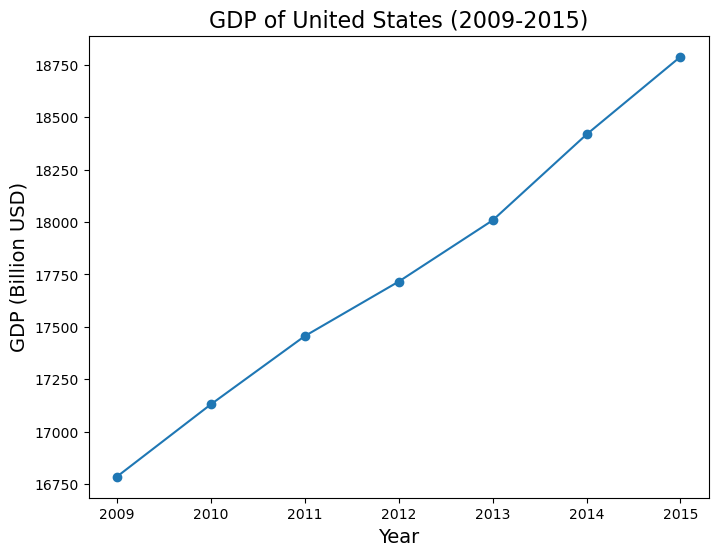

Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
--------------------
FINAL ANSWER: The line graph above shows the GDP of the United States from 2009 to 2015. The x-axis represents the years, and the y-axis represents the GDP value in billions of US dollars. The data points are marked with circles, and the line connects them to visualize the trend over time. The GDP increased year-over-year during this period, growing from around $16.8 trillion in 2009 to over $18.7 trillion in 2015.
CPU times: user 793 ms, sys: 176 ms, total: 970 ms
Wall time: 17.1 s


In [8]:
%%time
messages = []

system_prompt = """You are a python code generator and executor AI.
Your task is to generate the python code from the context provided and generate charts using the tools available to you to meet the user's requirement.
Once you have arrived at the final answer for the user's requirement then you are to strictly prefix it with FINAL ANSWER."""

code_generate_and_executor_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig_pythonrepl, messages=messages, color='GREEN')

output_chart_generator = code_generate_and_executor_agent.invoke(f"User's Requirement: Plot the line graph showing the GDP of United States\nInformation: {output_researcher}")

print(output_chart_generator)

<h3>Setting up Multi Agent System</h3>

We will now setup the Multi Agent System. We shall use the Agents/Prompts/Tool configurations that we created previously as a subroutine. 

Previously defined agents will become tools for our Manager Agent, this Manager agent will be responsible to orchestrate the calling of the individual agents on need basis till the user's query is answers.

Note: We have used `cyan` color for any output generated by the researcher agent, `green` color for any output generated by the code generation and execution agent and `magenta` color for any output generated by the orchestrator agent.

In [9]:
def researcher_agent_tool(query):
    messages = []
    system_prompt = """You are a researcher AI.
    Your task is to think step by step and break down the user's requirements use the tools available to you and answer the user's query to the best of your capabilities.
    Your answers should only come from the tools that are available wihtout any additional infomration outside the tool's responses
    When you have final answer to the user's query then you are to strictly prefix it with FINAL ANSWER to stop the iterations."""
    researcher_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig_websearch, messages=messages, color='CYAN')
    output_researcher = researcher_agent.invoke(query)
    return output_researcher

def code_generate_and_executor_agent_tool(task, related_information):
    messages = []
    system_prompt = """You are a python code generator and executor AI.
    Your task is to generate the python code from the context provided and generate charts using the tools available to you to meet the user's requirement.
    Once you have arrived at the final answer for the user's requirement then you are to strictly prefix it with FINAL ANSWER."""
    code_generate_and_executor_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig_pythonrepl, messages=messages, color='GREEN')
    output_chart_generator = code_generate_and_executor_agent.invoke(f"User's Requirement: {task}\nInformation: {related_information}")
    return output_chart_generator



toolConfig_multi_agent = {
    'tools': [
        {
            'toolSpec': {
                'name': 'researcher_agent_tool',
                'description': 'Researcher AI tool that is helpful for collecting factual information available on the internet',
                'inputSchema': {
                    'json': {
                        'type': 'object',
                        'properties': {
                            'query': {
                                'type': 'string',
                                'description': 'Query for which information is required.'
                            }
                        },
                        'required': ['query']
                    }
                }
            }
        }, {
            'toolSpec': {
                'name': 'code_generate_and_executor_agent_tool',
                'description': """This is a python code generator and executor AI Tool. 
When it is provided with the task for which code is required and the information related to the task it will generate the python code and the graphs that are required in the task.
                """,
                'inputSchema': {
                    'json': {
                        'type': 'object',
                        'properties': {
                            'task': {
                                'type': 'string',
                                'description': 'Task for which python code and the chart is requrired.'
                            },
                            'related_information': {
                                'type': 'string',
                                'description': 'Information Related to the task that will help with writing the python code for the charts that are needed to be generated.'
                            }
                        },
                        'required': ['task', 'related_information']
                    }
                }
            }
        }
    ],
    'toolChoice': {
        'auto': {}
    }
}

<h3>Testing Multi Agent System</h3>

We will first test our multi agent system with by asking it to `Plot the GDP in USD of India from 2009 to 2015 as a line graph`.

Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_jMe8G6VGSCq5aWMgDh-UkQ', 'name': 'researcher_agent_tool', 'input': {'query': 'India GDP in USD from 2009 to 2015'}}]
Function calling - Calling Tool
Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_QuXpdIsAQvW842tTl3kkEA', 'name': 'web_search', 'input': {'query': 'India GDP in USD 2009 to 2015'}}]
Function calling - Calling Tool
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
--------------------
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_SeYtiyJEQJGM3Is3mCMN2Q', 'name': 'code_generate_and_executor_agent_tool', 'input': {'task': "Generate a line char

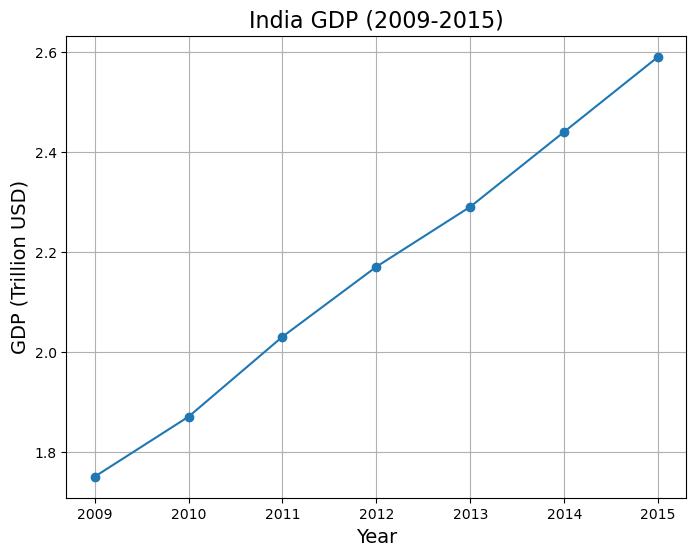

Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
--------------------
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
LLM Parser Invoked
LLM Parser Output: Here is the line chart plotting India's GDP in USD from 2009 to 2015 based on the provided data:

[A line chart is displayed showing India's GDP in USD (in trillions) on the y-axis and the years from 2009 to 2015 on the x-axis. The line shows a steady increase in GDP from $1.75 trillion in 2009 to $2.59 trillion in 2015.]
--------------------
Here is the line chart plotting India's GDP in USD from 2009 to 2015 based on the provided data:

[A line chart is displayed showing India's GDP in USD (in trillions) on the y-axis and the years from 2009 to 2015 on the x-axis. The line shows a steady increase in GDP from $1.75 trillion in 2009 to $2.59 trillion in 2

In [10]:
%%time
messages = []

system_prompt = """You are a Multi Agent AI System who has access to multiple AI tools.
Your task is to think step by step about the user's requirements and break it down into small actionable pieces that could be solved using the AI tools that are available to you.
When any of your tool is given a task, they will independently work on it to the best of their capabilities. 
These tool with return either information related to the user's requirement or return what they have done, you are to use that information and proceed with either judging if the user's requirement is meet or if you will have to use the tools more to meet user's requirements.
When you have judged that you have met the user's requirements then you are to strictly prefix it with FINAL ANSWER to stop the iterations.
"""

multi_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig_multi_agent, messages=messages, color='MAGENTA')

output_multi_agent = multi_agent.invoke(f"Plot the GDP in USD of India from 2009 to 2015 as a line graph")

print(output_multi_agent)

We will next re-intiatilize our multi agent system and ask it to compare the `Compare the GDP in USD of India and China from 2009 to 2015 on a graph.`.

Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_aWXQp6qCSfySJq6bB6Gx2w', 'name': 'researcher_agent_tool', 'input': {'query': 'GDP in USD of India and China from 2009 to 2015'}}]
Function calling - Calling Tool
Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_hvFn8PK4RtWocc5yYBrMCQ', 'name': 'web_search', 'input': {'query': 'GDP of India and China in USD from 2009 to 2015'}}]
Function calling - Calling Tool
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_MsbicByRSliDsTEnYSKtwg', 'name': 'web_search', 'input': {'query': 'India and China GDP in USD from 2009 to 2015'}}]
Function calling - Calling Tool
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Func

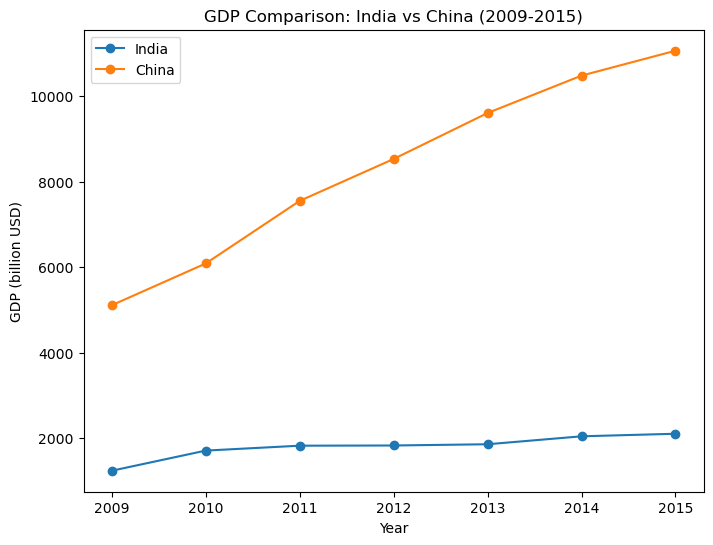

Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
--------------------
Function calling - Received Tool Response
Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
LLM Parser Invoked
LLM Parser Output: The provided code generates a line chart comparing the GDP in USD of India and China from 2009 to 2015. The chart clearly shows that China had a significantly higher GDP than India during this period, with China's GDP values being approximately 3-5 times higher than India's GDP values across the years. The lines highlight the increasing trend in GDP for both countries over time, with China's GDP growing at a faster rate compared to India.
--------------------
The provided code generates a line chart comparing the GDP in USD of India and China from 2009 to 2015. The chart clearly shows that China had a significantly higher GDP than India during this period

In [11]:
multi_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig_multi_agent, messages=[], color='MAGENTA')

output_multi_agent = multi_agent.invoke(f"Compare the GDP in USD of India and China from 2009 to 2015 on a graph.")

print(output_multi_agent)

<h2>Summary</h2>

In this notebook we saw the following:
<ol>
    <li>How custom python functions can be defined as tools and used in Bedrock Converse API.</li>
    <li>Custom implementation of Agents and how they work internally.</li>
    <li>How the custom agents can be leveraged to create multi agent systems.</li>
</ol>

<h2>Next Steps</h2>

You can choose to change the base agent class behaviour or extend the functionality of individual agents by providing them with more tools and adding more agent to the orchestrator agent as tools achieve competencies in complex tasks.

<h2>Cleanup</h2>

You can choose to delete the execution role, if you do not plan to use it again.